<a href="https://colab.research.google.com/github/jungry/time_series/blob/main/TimeSeries_Practice13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering
Feature Engineering은 기계학습 모델을 위한 데이터를 준비하는 중요한 과정이다. 이는 원시 데이터를 모델의 예측 성능을 향상시킬 수 있는 의미있는 특성으로 변환하는 작업을 포함한다. 시계열 데이터의 경우, 데이터의 시간적 특성 때문에 Feature Engineering에는 특수한 기술이 필요하다. 이 실습에서는 시간, 주파수, 그리고 두가지를 결합한 Feature Engineering 방법을 다양한 분야에서 탐구할 것이다. 또한, mobility data 와 text data 처리 기술도 다룰것임.

## 1. Time Domain
시간 영역(time domain)은 시간에 따른 데이터 포인트를 분석하여 의미 있는 특성을 추출하는 과정이다. 이 섹션에서는 수치 데이터 추출, 범주형 데이터 인코딩, 패턴 마이닝, 혼합 데이터 처리 방법을 다룬다.

### 1.1 Numerical Data (Basic Statistical Feature)
수치형 특성은 통계적 측정값과 윈도잉 기법을 사용하여 시계열 데이터에서 도출된다. 이러한 특성은 데이터의 기본적인 패턴과 추세를 포착하는 데 도움이 된다.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


MultiIndex([('Adj Close', 'BTC-USD'),
            (    'Close', 'BTC-USD'),
            (     'High', 'BTC-USD'),
            (      'Low', 'BTC-USD'),
            (     'Open', 'BTC-USD'),
            (   'Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])


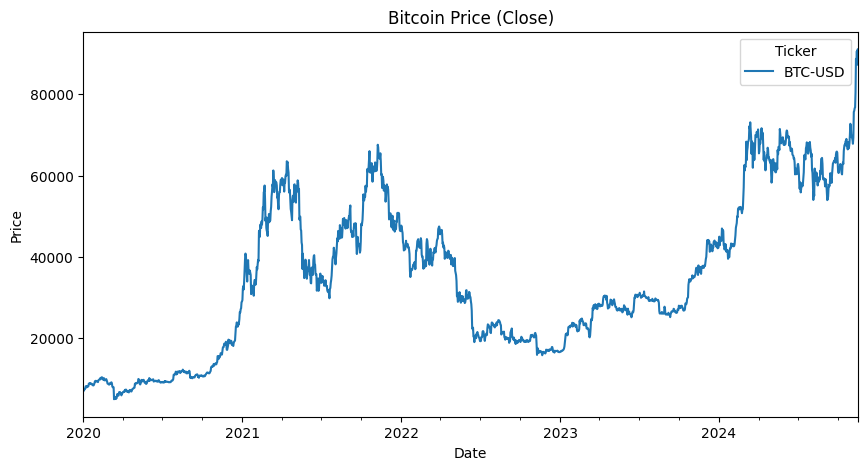

In [4]:
# 'BTC-USD' 데이터를 2020년 1월 1일부터 2024년 11월 17일까지 다운로드
btc_data = yf.download("BTC-USD", start="2020-01-01", end="2024-11-17")

# 데이터의 열 이름을 출력하여 확인
print(btc_data.columns)

# 'Date'라는 새로운 열을 생성하여 기존 인덱스를 날짜로 저장
btc_data['Date'] = btc_data.index

# 종가(Close) 가격에 대한 시각화
btc_data['Close'].plot(figsize=(10, 5), title="Bitcoin Price (Close)", xlabel="Date", ylabel="Price")
plt.show()

#### Sliding Window

슬라이딩 윈도우는 시계열 데이터의 한 구간으로, 전체 데이터셋을 가로지르며 이동합니다. 윈도우의 크기와 유형은 추출되는 특성에 큰 영향을 미칠 수 있습니다.

	•	구별된 윈도우(Distinct Windowing): 겹치지 않는 윈도우로, 시계열을 독립적인 구간으로 나누어 분석하는 데 유용합니다.
	•	겹치는 윈도우(Overlapped Windowing): 서로 겹치는 윈도우로, 연속적이고 부드러운 특성 추출 과정을 제공합니다.

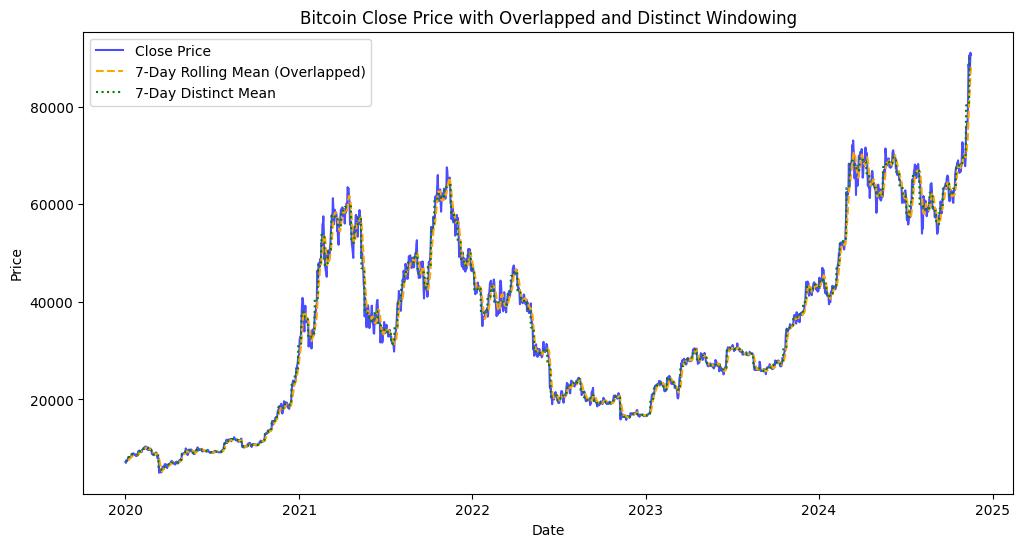

In [9]:
# Overlapped Windowing
#데이터의 단기적인 변동을 부드럽게. 장기적 트렌드나 패턴을 더 쉽게 볼 수 있음.
window_size = 7 #7일의 데이터를 기반으로 데이터를 하나씩 "이동"하면서 각 시점에서 최근 7일동안의 이동평균과 이동표준편차 계산
btc_close_rolling_mean = btc_data['Close'].rolling(window=window_size).mean()
btc_close_rolling_std = btc_data['Close'].rolling(window=window_size).std()

# Distinct Windowing
#close열의 길이만큼 range로 0,2,3,...숫자 생성. 그 옆에는 그 시점의 날짜. -> window size(7)로 나누면 각 구간이 나누어짐.
group_ids = (pd.Series(range(len(btc_data['Close'])), index=btc_data['Close'].index) // window_size)
#groupby로 구간을 나누고 transform을 사용하여 각 그룹의 평균과 표준편차 계산.
btc_close_distinct_mean = btc_data['Close'].groupby(group_ids).transform("mean")
btc_close_distinct_std = btc_data['Close'].groupby(group_ids).transform("std")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(btc_data['Close'], label="Close Price", alpha=0.7, color="blue")
plt.plot(btc_close_rolling_mean, label=f"{window_size}-Day Rolling Mean (Overlapped)", linestyle="--", color="orange")
plt.plot(btc_close_distinct_mean, label=f"{window_size}-Day Distinct Mean", linestyle=":", color="green")
plt.title("Bitcoin Close Price with Overlapped and Distinct Windowing")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

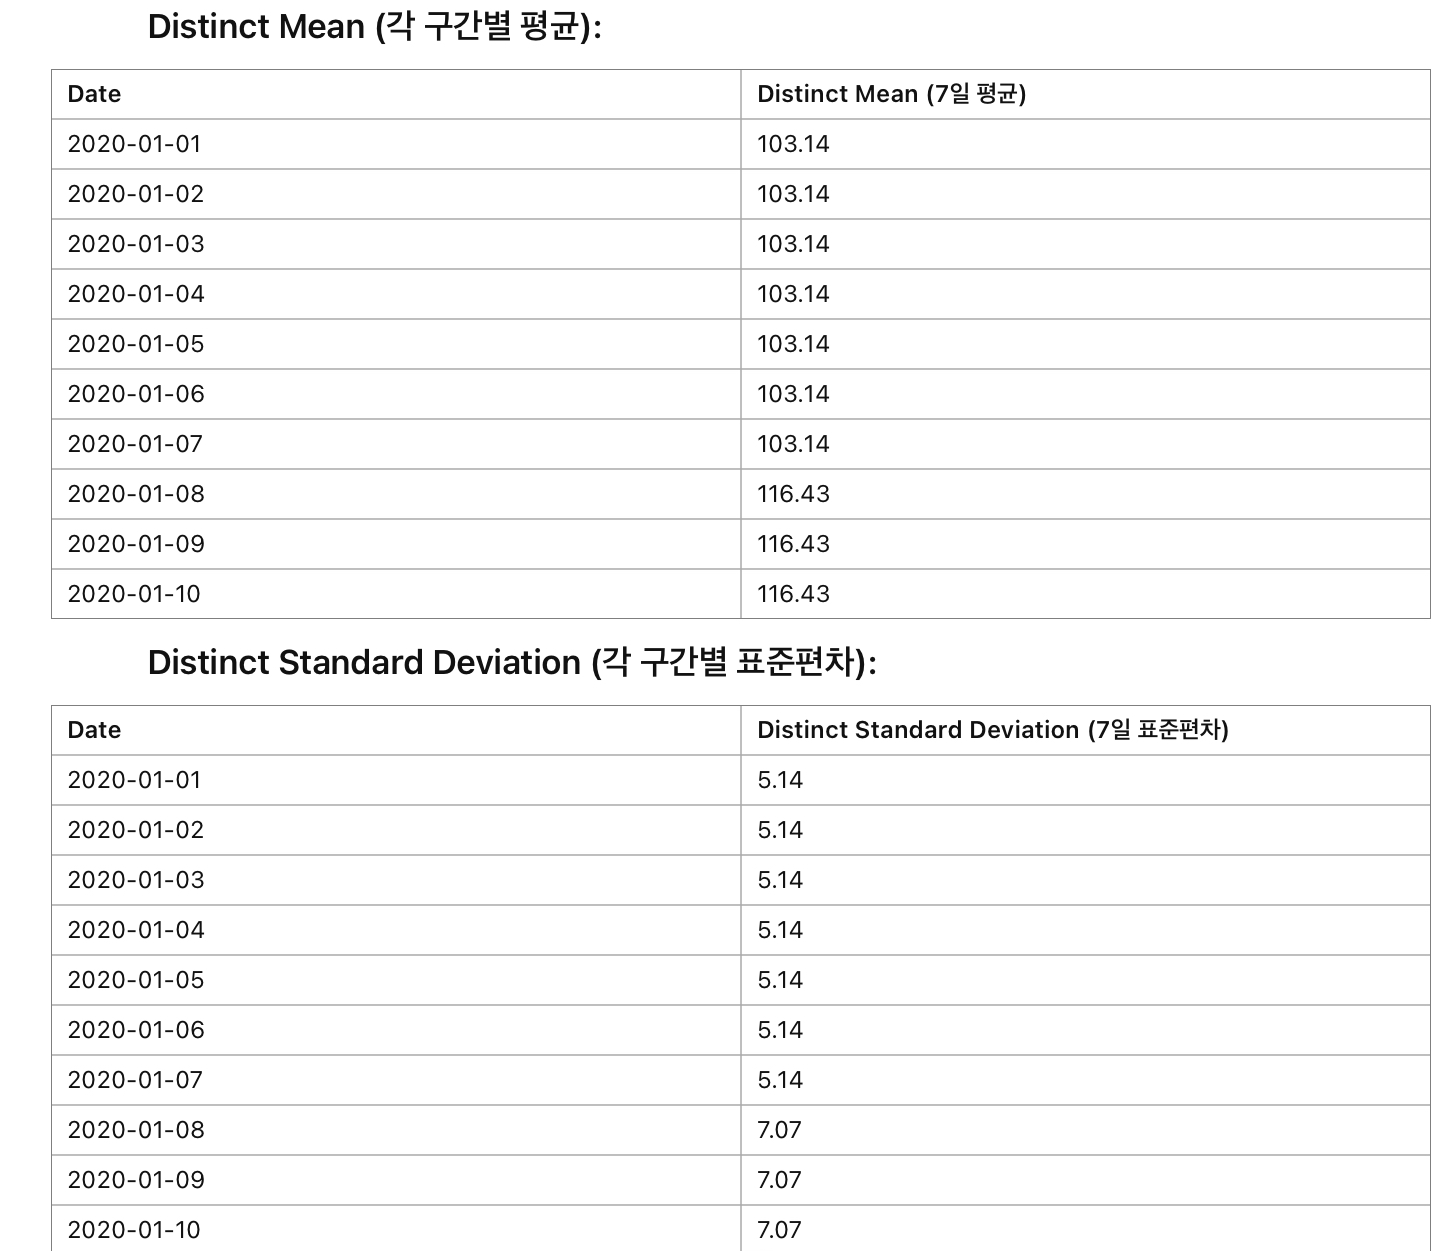

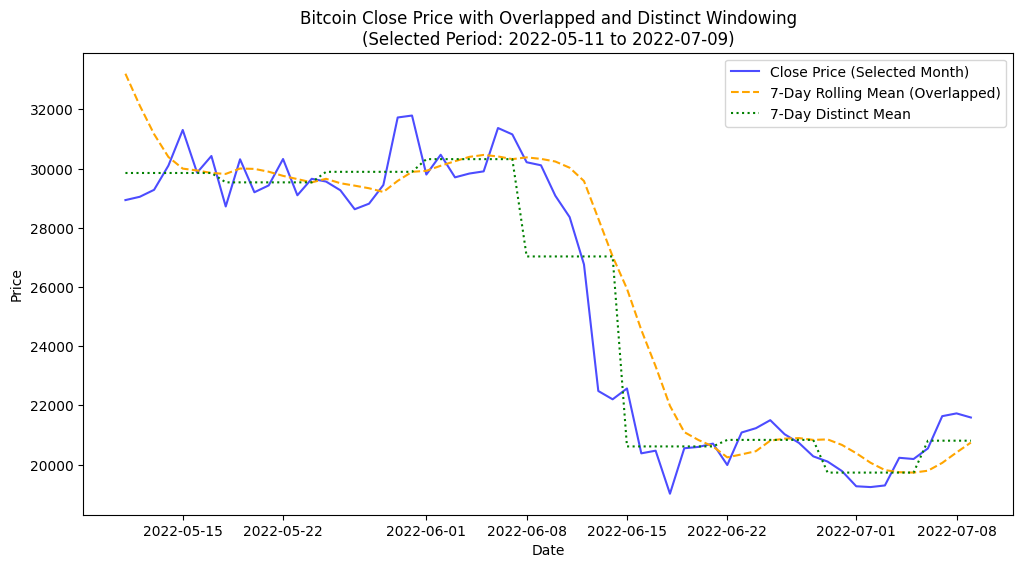

In [10]:
# 한 달 간의 기간을 선택 (중앙 부분을 확대) 조금 더 자세하게 보자 ~
#BTC 데이터의 중간 인덱스에서 30일 전부터 60일 동안의 데이터를 선택
month_start_index = len(btc_data['Close']) // 2 - 30
month_period = btc_data['Close'].iloc[month_start_index:month_start_index + 60]

# 선택된 한 달에 해당하는 이동평균(rolling mean) 값 추출
month_rolling_mean = btc_close_rolling_mean.iloc[month_start_index:month_start_index + 60]
#선택된 한 달에 해당하는 Distinct Windowing 평균 값 추출
month_distinct_mean = btc_close_distinct_mean.iloc[month_start_index:month_start_index + 60]

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(month_period, label="Close Price (Selected Month)", alpha=0.7, color="blue")
plt.plot(month_rolling_mean, label="7-Day Rolling Mean (Overlapped)", linestyle="--", color="orange")
plt.plot(month_distinct_mean, label="7-Day Distinct Mean", linestyle=":", color="green")
plt.title(f"Bitcoin Close Price with Overlapped and Distinct Windowing\n(Selected Period: {month_period.index[0].date()} to {month_period.index[-1].date()})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

롤링 윈도우 (Rolling Window)

1.	데이터가 연속적이며, 미세한 시간 변화도 캡처해야 할 때
2.	실시간 분석 또는 트렌드 예측이 목표일 때

예시: 주식 가격, 웨어러블 센서 데이터, 전력 소비 데이터 등

구간 윈도우 (Distinct Window)

1.	데이터를 고정된 구간으로 요약하거나 넓은 패턴을 포착하는 데 집중할 때
2.	계산 효율성이 중요한 경우

ex) EMA 데이터, 교통(승객 수 또는 차량 수) 데이터 등

<추천>

1.	미세한 패턴을 모델링하려면 롤링 윈도우를 사용하세요.
2.	구간 요약을 제공하고 모델을 단순화하려면 구간 윈도우를 사용하세요.

In [11]:
window_sizes = [7, 30]  # 윈도우 크기를 7과 30으로 설정
for window in window_sizes:  # 7과 30에 대해 각각 계산을 진행
    btc_data[f'Rolling_Mean_{window}'] = btc_data['Close'].rolling(window=window).mean()  # 각 윈도우 크기에서의 롤링 평균을 계산하여 새로운 열에 저장
    btc_data[f'Rolling_Std_{window}'] = btc_data['Close'].rolling(window=window).std()  # 각 윈도우 크기에서의 롤링 표준편차를 계산하여 새로운 열에 저장
    btc_data[f'Rolling_Min_{window}'] = btc_data['Close'].rolling(window=window).min()  # 각 윈도우 크기에서의 롤링 최소값을 계산하여 새로운 열에 저장
    btc_data[f'Rolling_Max_{window}'] = btc_data['Close'].rolling(window=window).max()  # 각 윈도우 크기에서의 롤링 최대값을 계산하여 새로운 열에 저장
    btc_data[f'Rolling_Range_{window}'] = btc_data[f'Rolling_Max_{window}'] - btc_data[f'Rolling_Min_{window}']  # 롤링 최대값과 최소값의 차이를 계산하여 롤링 범위 열에 저장

    # Assuming `btc_data` has already been calculated and you print the first few rows
print(btc_data[['Close', 'Rolling_Mean_7', 'Rolling_Std_7', 'Rolling_Min_7', 'Rolling_Max_7', 'Rolling_Range_7']].head())

Price                            Close Rolling_Mean_7 Rolling_Std_7  \
Ticker                         BTC-USD                                
Date                                                                  
2020-01-01 00:00:00+00:00  7200.174316            NaN           NaN   
2020-01-02 00:00:00+00:00  6985.470215            NaN           NaN   
2020-01-03 00:00:00+00:00  7344.884277            NaN           NaN   
2020-01-04 00:00:00+00:00  7410.656738            NaN           NaN   
2020-01-05 00:00:00+00:00  7411.317383            NaN           NaN   

Price                     Rolling_Min_7 Rolling_Max_7 Rolling_Range_7  
Ticker                                                                 
Date                                                                   
2020-01-01 00:00:00+00:00           NaN           NaN             NaN  
2020-01-02 00:00:00+00:00           NaN           NaN             NaN  
2020-01-03 00:00:00+00:00           NaN           NaN             NaN  

2020-01-01부터 2020-01-06까지는 7일의 롤링 평균을 구할 수 없기 때문에 NaN 값이 나옵니다. <br>
2020-01-07부터는 7일 동안의 데이터가 있으므로 계산이 가능하고, 7일 롤링 평균 값이 나오게 됩니다.


### 1.2 Domain Specific (Crypto Currencies)
1.	거래량 기반 특성 (Volume-Based Features):

	•	높은 거래량은 가격 상승을 시사하며, 낮은 거래량은 가격 변동성을 줄일 가능성이 있습니다.

	•	거래량-가격 비율 (Volume-Price Ratio) 및 거래량 모멘텀 (Volume Momentum): 관련 연구들은 거래량 증가가 종종 중요한 가격 변화를 예고하며, 따라서 거래량 기반 특성들이 가격 변화를 예측하는 선행 지표로 사용될 수 있음을 보여줍니다.
2.	변동성 기반 특성 (Volatility-Based Features):
	•	높은 변동성은 가격 극단을 초래할 가능성이 높고, 낮은 변동성은 안정적인 추세를 예고할 가능성이 큽니다.

	•	고가-저가 변동성 (High-Low Volatility) 및 볼린저 밴드 (Bollinger Bands): 관련 연구는 고가-저가 변동성 및 볼린저 밴드와 같은 기술 지표들이 시장 변동성을 포착하는 데 효과적임을 입증했습니다.

3.	기술적 지표 (Technical Indicators):
	•	RSI (상대 강도 지수, Relative Strength Index): 가격 상승과 하락의 강도를 비교하여 과매수(overbought) 또는 과매도(oversold) 상태를 나타냅니다.

	•	70 이상은 **과매수(overbought)**로 하락할 가능성이 높고, 30 이하일 경우 **과매도(oversold)**로 상승할 가능성이 높습니다.

  Overbought는 특정 자산이 지나치게 매수되어 가격이 지나치게 상승한 상태를 말함.<br>
  Oversold는 특정 자산이 지나치게 매도되어 가격이 지나치게 하락한 상태를 말함.


[1] (2021, Financial Innovation) Changing market conditions에서 기계학습을 이용한 암호화폐 예측 및 거래

[2] (2022, Journal of Big Data) 다변량 암호화폐 예측: 세 가지 순환 신경망 접근 방식의 비교 분석

In [13]:
#ta 라이브러리는 Python을 사용하여 기술적 분석 (Technical Analysis) 지표를 계산할 수 있도록 돕는 라이브러리이다.
#주로 주식, 암호화폐, 외환 등 금융 시장의 데이터 분석에 사용됨
pip install --upgrade ta

In [14]:
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# Volume-Based Features(거래량 기반 특성) 거래량과 종가의 비율
btc_data['Volume_Price_Ratio'] = btc_data['Volume'] / btc_data['Close']
#거래량의 차이 계산
btc_data['Volume_Momentum'] = btc_data['Volume'].diff()

# Volatility-Based Features(변동성 기반 특성)
#High_Low_Volatility: 고가(High)와 저가(Low)의 차이를 구하여 변동성을 계산함. 가격이 많이 변동하면 고가와 저가의 차이가 커지고, 변동성이 크다는 것을 의미.
btc_data['High_Low_Volatility'] = btc_data['High'] - btc_data['Low']
bollinger = BollingerBands(close=btc_data['Close'].squeeze(), window=20)
#상단 볼린저 밴드를 계산하여 Bollinger_High 컬럼에 저장.
btc_data['Bollinger_High'] = bollinger.bollinger_hband().values.ravel()  # Convert to 1D
#하단 볼린저 밴드를 계산하여 Bollinger_Low 컬럼에 저장.
btc_data['Bollinger_Low'] = bollinger.bollinger_lband().values.ravel()

# Technical Indicators(기술적 지표)
rsi = RSIIndicator(close=btc_data['Close'].squeeze(), window=14)
btc_data['RSI'] = rsi.rsi().squeeze()  # Squeeze to ensure 1D


.diff(): 각 데이터 포인트의 이전 값과의 차이를 계산하는 함수로, 거래량의 변화량을 나타낸다.

 이 값은 거래량의 증가나 감소 추세를 확인하는 데 사용됩니다.

 squeeze()는 데이터가 1D 배열 형태로 바뀌도록 해줍니다.

 .values.ravel()을 사용하여 1차원 배열로 반환하여, NaN 값을 제거하는데 유용

 window=14: 14일 기간에 대해 RSI(상대 강도 지수)를 계산합니다.

RSI: 과매도(oversold) 또는 과매수(overbought) 상태를 파악하는 데 사용되는 지표

.rsi(): RSI 값을 계산하여 반환합니다. squeeze()를 사용하여 1D 배열로 반환합니다.



In [ ]:
#비트코인 가격 데이터에 대해 변동성 및 거래량 모멘텀을 계산하고,
#특정 조건에 따라 Volume_Momentum 컬럼을 제거하는 과정을 다룬다.
btc_data['High_Low_Volatility'] = btc_data['High'] - btc_data['Low']
btc_data['High_Low_Volatility']

btc_data['High'] - btc_data['Low']
btc_data['Volume'].diff()
btc_data['Volume_Momentum'] = btc_data['Volume'].diff()
btc_data['Volume_Momentum']
btc_data['Volume'].diff()
btc_data['Volume_Momentum'] = btc_data['Volume'].diff()
btc_data['Volume_Momentum']
# Volume_Momentum
if 'Volume_Momentum' in btc_data.columns:
    btc_data.drop(columns=['Volume_Momentum'], inplace=True)

# diff()
btc_data['Volume_Momentum'] = btc_data['Volume'].diff()
btc_data['Volume_Momentum']

<ipython-input-54-3272163f16ed>:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  btc_data.drop(columns=['Volume_Momentum'], inplace=True)


,Volume_Momentum
Date,
2020-01-01 00:00:00+00:00,NaN
2020-01-02 00:00:00+00:00,2.236418e+09
2020-01-03 00:00:00+00:00,7.309398e+09
2020-01-04 00:00:00+00:00,-9.667210e+09
2020-01-05 00:00:00+00:00,1.280803e+09
...,...
2024-11-12 00:00:00+00:00,1.570644e+10
2024-11-13 00:00:00+00:00,-1.011426e+10
2024-11-14 00:00:00+00:00,-3.594232e+10


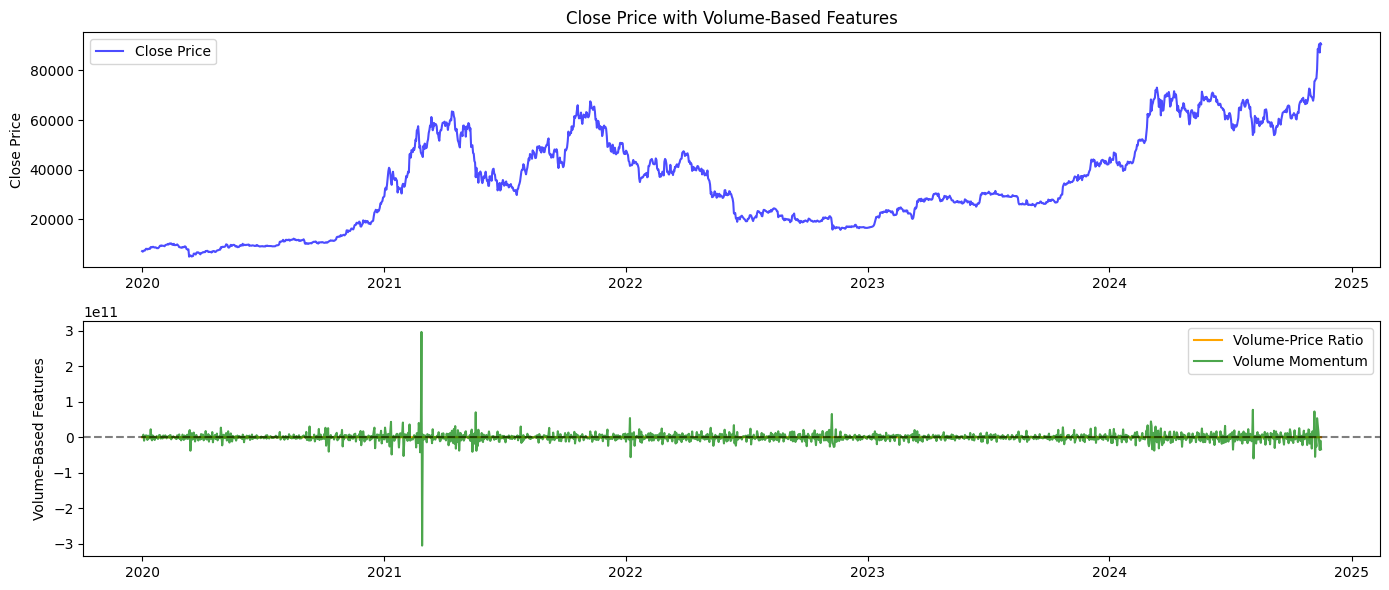

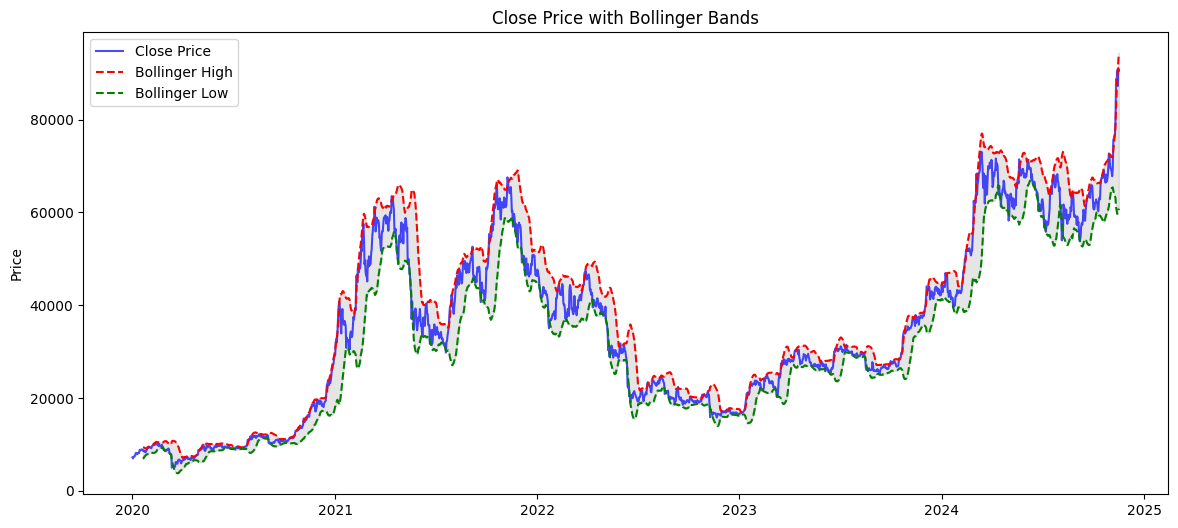

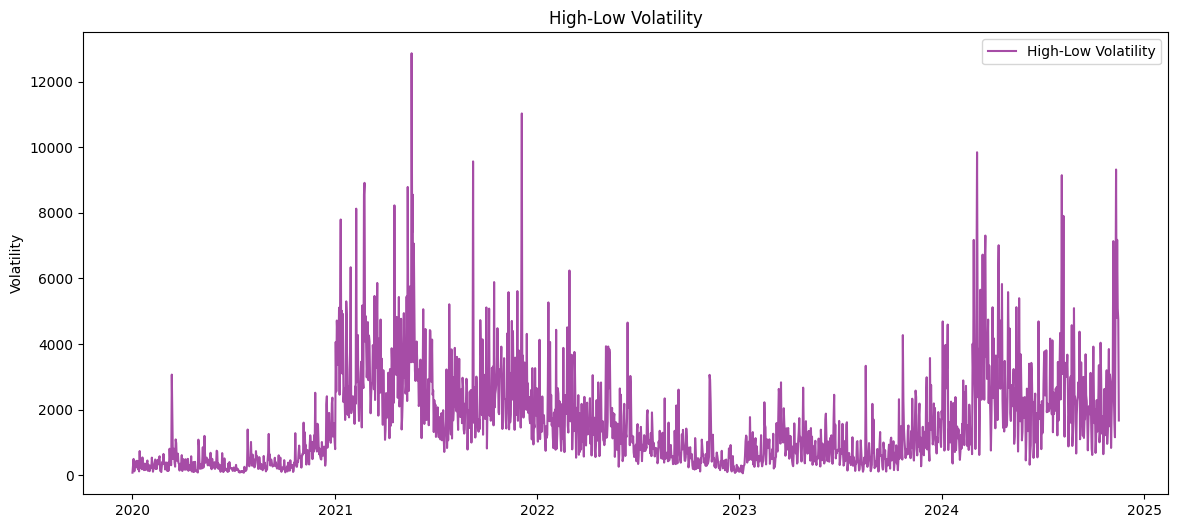

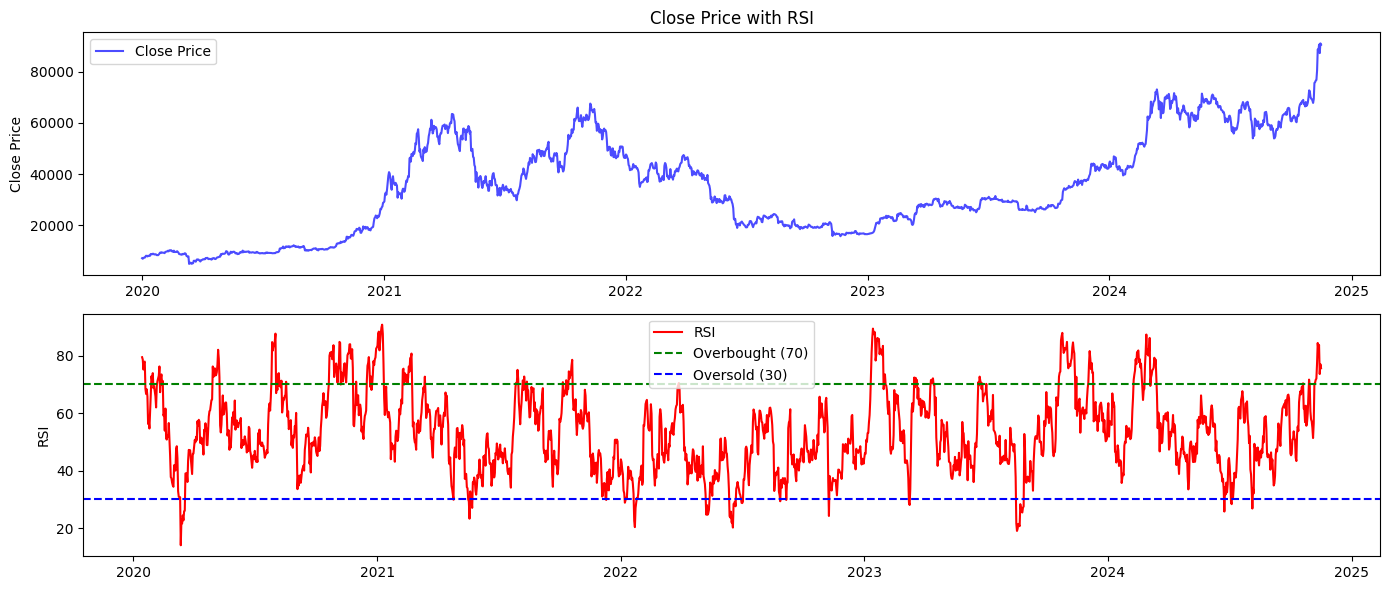

In [ ]:
# 1. Volume-Based Features Visualization
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(btc_data['Close'], label='Close Price', color='blue', alpha=0.7)
plt.title('Close Price with Volume-Based Features')
plt.ylabel('Close Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(btc_data['Volume_Price_Ratio'], label='Volume-Price Ratio', color='orange')
plt.plot(btc_data['Volume_Momentum'], label='Volume Momentum', color='green', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.ylabel('Volume-Based Features')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Volatility-Based Features Visualization
plt.figure(figsize=(14, 6))
plt.plot(btc_data['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(btc_data['Bollinger_High'], label='Bollinger High', color='red', linestyle='--')
plt.plot(btc_data['Bollinger_Low'], label='Bollinger Low', color='green', linestyle='--')
plt.fill_between(btc_data.index, btc_data['Bollinger_Low'], btc_data['Bollinger_High'], color='grey', alpha=0.2)
plt.title('Close Price with Bollinger Bands')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(btc_data['High_Low_Volatility'], label='High-Low Volatility', color='purple', alpha=0.7)
plt.title('High-Low Volatility')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# 3. Technical Indicators Visualization
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(btc_data['Close'], label='Close Price', color='blue', alpha=0.7)
plt.title('Close Price with RSI')
plt.ylabel('Close Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(btc_data['RSI'], label='RSI', color='red')
plt.axhline(70, color='green', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='blue', linestyle='--', label='Oversold (30)')
plt.ylabel('RSI')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Create a target variable (predicting the next day's closing price)

btc_data['Target_Close'] = btc_data['Close'].shift(-1)

In [ ]:
# Separate features and target variables
features = [
    'Volume_Price_Ratio', 'Volume_Momentum', 'High_Low_Volatility',
    'Bollinger_High', 'Bollinger_Low', 'RSI',
    'Rolling_Mean_7', 'Rolling_Std_7', 'Rolling_Min_7', 'Rolling_Max_7', 'Rolling_Range_7',
    'Rolling_Mean_30', 'Rolling_Std_30', 'Rolling_Min_30', 'Rolling_Max_30', 'Rolling_Range_30'
]
btc_data = btc_data.dropna()

X = btc_data[features]
y = btc_data['Target_Close']


### 1.3 Categorical/Nominal Data
Categorical or nominal data in time series is often represented by discrete labels or categories. These need to be encoded into numerical form to be used in machine learning models.

Encoding Techniques
* **OneHotEncoding**: Converts categorical variables into binary vectors, where each unique category is represented by a column.
* **Dummy Variables**: Similar to OneHotEncoding but often drops one column to avoid the dummy variable trap, reducing multicollinearity.
  
  * Multicollinearity : A situation where there is a strong correlation between independent variables (ex. BMI & Weight)

In [ ]:
# Load the dataset
weather_data = pd.read_csv('/content/drive/Shared drives/timeseries-datasets/seoul 2022-01-01 to 2024-01-01.csv')
weather_data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,seoul,2022-01-01,2.0,-10.2,-4.7,0.3,-15.0,-6.6,-15.2,44.3,...,9.9,5,NaN,2022-01-01T07:46:54,2022-01-01T17:24:04,0.94,Clear,Clear conditions throughout the day.,clear-day,"47098099999,47112099999,47119099999,4712209999..."
1,seoul,2022-01-02,2.6,-4.4,-1.1,-0.5,-8.6,-4.0,-8.4,58.9,...,10.1,5,NaN,2022-01-02T07:47:03,2022-01-02T17:24:52,0.98,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"47111099999,47098099999,47112099999,4711909999..."
2,seoul,2022-01-03,2.2,-7.7,-2.4,0.6,-11.5,-4.7,-10.1,56.4,...,9.8,5,NaN,2022-01-03T07:47:10,2022-01-03T17:25:41,0.00,"Snow, Rain, Partially cloudy",Becoming cloudy in the afternoon with late aft...,rain,"47111099999,47098099999,47112099999,4711909999..."
3,seoul,2022-01-04,1.0,-5.0,-1.9,0.6,-9.1,-4.7,-10.6,54.8,...,10.9,5,NaN,2022-01-04T07:47:15,2022-01-04T17:26:32,0.04,Snow,Clear conditions throughout the day with late ...,rain,"47111099999,47098099999,47112099999,4711909999..."
4,seoul,2022-01-05,1.7,-7.7,-3.1,1.7,-12.0,-4.9,-13.0,46.7,...,6.1,3,NaN,2022-01-05T07:47:18,2022-01-05T17:27:23,0.08,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"47111099999,47098099999,47112099999,4711909999..."


In [ ]:
# Get more information about the dataset
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              731 non-null    object 
 1   datetime          731 non-null    object 
 2   tempmax           731 non-null    float64
 3   tempmin           731 non-null    float64
 4   temp              731 non-null    float64
 5   feelslikemax      731 non-null    float64
 6   feelslikemin      731 non-null    float64
 7   feelslike         731 non-null    float64
 8   dew               731 non-null    float64
 9   humidity          731 non-null    float64
 10  precip            731 non-null    float64
 11  precipprob        731 non-null    int64  
 12  precipcover       731 non-null    float64
 13  preciptype        345 non-null    object 
 14  snow              731 non-null    float64
 15  snowdepth         731 non-null    float64
 16  windgust          731 non-null    float64
 1

In [ ]:
object_columns = weather_data.select_dtypes(include=['object'])
object_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         731 non-null    object
 1   datetime     731 non-null    object
 2   preciptype   345 non-null    object
 3   sunrise      731 non-null    object
 4   sunset       731 non-null    object
 5   conditions   731 non-null    object
 6   description  731 non-null    object
 7   icon         731 non-null    object
 8   stations     731 non-null    object
dtypes: object(9)
memory usage: 51.5+ KB


In [ ]:
# 'icon' : Overall weather conditions [ex] 'clear-day', 'rain', 'cloudy', etc
weather_data['icon'].fillna('unknown', inplace=True)
# 'preciptype' [ex] Rain, snow, sleet, etc
weather_data['preciptype'].fillna('unknown', inplace=True)

<ipython-input-68-b42e597c52ec>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_data['icon'].fillna('unknown', inplace=True)
<ipython-input-68-b42e597c52ec>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [ ]:
# One-Hot Encoding
one_hot_encoded = pd.get_dummies(weather_data, columns=['icon', 'preciptype'], drop_first=False)
#print("\nOne-Hot Encoded DataFrame:")
#print(one_hot_encoded.info())
# Select only relevant columns 'icon' 및 'preciptype'
one_hot_columns = [col for col in one_hot_encoded.columns if 'icon_' in col or 'preciptype_' in col]
one_hot_selected_data = one_hot_encoded[one_hot_columns]

# Output
print("\nOne-Hot Encoded Columns (Only 'icon' and 'preciptype'):")
print(one_hot_selected_data.head())


One-Hot Encoded Columns (Only 'icon' and 'preciptype'):
   icon_clear-day  icon_cloudy  icon_partly-cloudy-day  icon_rain  icon_snow  \
0            True        False                   False      False      False   
1           False        False                   False       True      False   
2           False        False                   False       True      False   
3           False        False                   False       True      False   
4           False        False                    True      False      False   

   preciptype_rain  preciptype_rain,snow  preciptype_snow  preciptype_unknown  
0            False                 False            False                True  
1            False                  True            False               False  
2            False                  True            False               False  
3            False                 False             True               False  
4            False                 False            False     

In [ ]:
# Dummy Variable Encoding (drop_first=True)
dummy_encoded = pd.get_dummies(weather_data, columns=['icon', 'preciptype'], drop_first=True)
#print("\nDummy Variable Encoded DataFrame:")
#print(dummy_encoded.info())

# Select only 'icon' and 'preciptype' related columns
dummy_columns = [col for col in dummy_encoded.columns if 'icon_' in col or 'preciptype_' in col]
dummy_selected_data = dummy_encoded[dummy_columns]

# Output
print("\nDummy Encoded Columns (Only 'icon' and 'preciptype'):")
print(dummy_selected_data.head())


Dummy Encoded Columns (Only 'icon' and 'preciptype'):
   icon_cloudy  icon_partly-cloudy-day  icon_rain  icon_snow  \
0        False                   False      False      False   
1        False                   False       True      False   
2        False                   False       True      False   
3        False                   False       True      False   
4        False                    True      False      False   

   preciptype_rain,snow  preciptype_snow  preciptype_unknown  
0                 False            False                True  
1                  True            False               False  
2                  True            False               False  
3                 False             True               False  
4                 False            False                True  


**One-Hot Encoding:** Useful when you want to preserve all categorical information. It can lead to multicollinearity if used without care in linear models.<br>
**Dummy Variable Encoding:** Reduces multicollinearity by dropping one category per feature, which is crucial for linear regression models where this redundancy can lead to unstable estimates.

In [ ]:
# Identify columns present in one-hot encoded but missing in dummy encoded
missing_columns = set(one_hot_encoded.columns) - set(dummy_encoded.columns)

print("Columns present in One-Hot Encoding but missing in Dummy Encoding:")
print(missing_columns)

Columns present in One-Hot Encoding but missing in Dummy Encoding:
{'preciptype_rain', 'icon_clear-day'}


### 1.4 Pattern Mining
Pattern mining focuses on discovering recurring patterns or motifs in time series data. These patterns can reveal insights into the underlying structure of the data.

Temporal Pattern Identification Algorithm<br>
**Support:** The frequency or proportion of the dataset that a pattern appears in, determining its significance.

In [ ]:
from scipy.signal import find_peaks

weather_data = pd.read_csv('/content/drive/Shared drives/timeseries-datasets/seoul 2022-01-01 to 2024-01-01.csv')
temperature_data = weather_data['temp']

# Find peaks in the temperature data
peaks, properties = find_peaks(temperature_data, height=27)

# Calculate support for each pattern (peak)
# support : Percentage of total data represented by the peak pattern
peak_support = len(peaks) / len(temperature_data)
print(f"Peak Count: {len(peaks)}, Support: {peak_support:.2f}")

Peak Count: 25, Support: 0.03


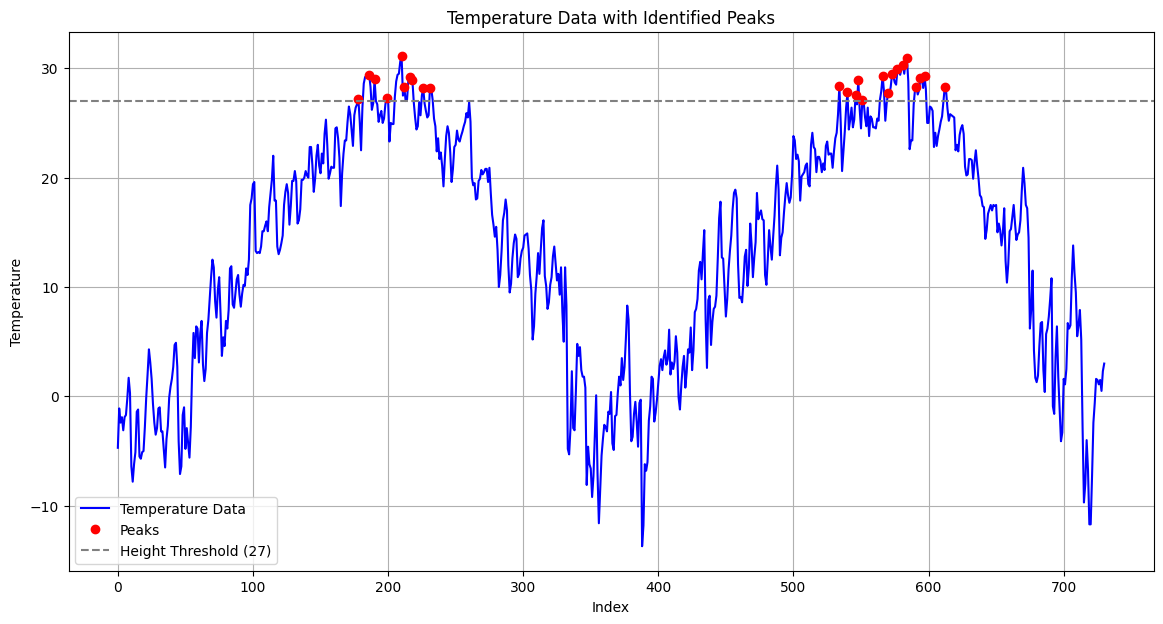

In [ ]:
# Plot the temperature data and peaks
plt.figure(figsize=(14, 7))
plt.plot(temperature_data, label='Temperature Data', color='blue')
plt.plot(peaks, temperature_data[peaks], 'ro', label='Peaks')
plt.axhline(y=27, color='gray', linestyle='--', label='Height Threshold (27)')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Temperature Data with Identified Peaks')
plt.legend()
plt.grid(True)
plt.show()

## 2. Frequency Domain
The frequency domain focuses on **decomposing time series data into its frequency components**, which can reveal periodic patterns and trends.

#### 2.1 Fourier Transformation
Goal : Extract cyclical features from data by converting from time domain to frequency domain

The Fourier Transform is a mathematical technique that decomposes a time series into sinusoidal components at different frequencies.
* Discrete Fourier Transform (DFT): A numerical method that computes the Fourier Transform for discrete data points.
* Fast Fourier Transform (FFT): An efficient algorithm for computing the DFT, reducing computational complexity.

Key Concepts
X(k): Represents the amplitude of the k-th sinusoidal component.

Sampling Frequency (
𝑓
𝑠
f
s
​
 ): The rate at which data points are sampled per unit of time.

Frequency (
𝐹
(
𝑘
)
F(k)): Calculated as
𝐹
(
𝑘
)
=
𝑓
𝑠
×
𝑘
/
𝑁
F(k)=f
s
​
 ×k/N, where
𝑁
N is the window size.

In [ ]:
from scipy.fft import fft, fftfreq

# Set datetime as the index
weather_data.set_index('datetime', inplace=True)

# Ensure there are no missing values (Fill in missing values with earlier values)
temperature_data = weather_data['temp'].fillna(method='ffill').values

# Define sampling rate (1 sample per day for daily data)
sampling_rate = 1  # Hz

# Number of samples
N = len(temperature_data)

# Calculate the FFT
yf = fft(temperature_data)
xf = fftfreq(N, d=1/sampling_rate)[:N//2]

<ipython-input-18-3da1d4a93b70>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temperature_data = weather_data['temp'].fillna(method='ffill').values


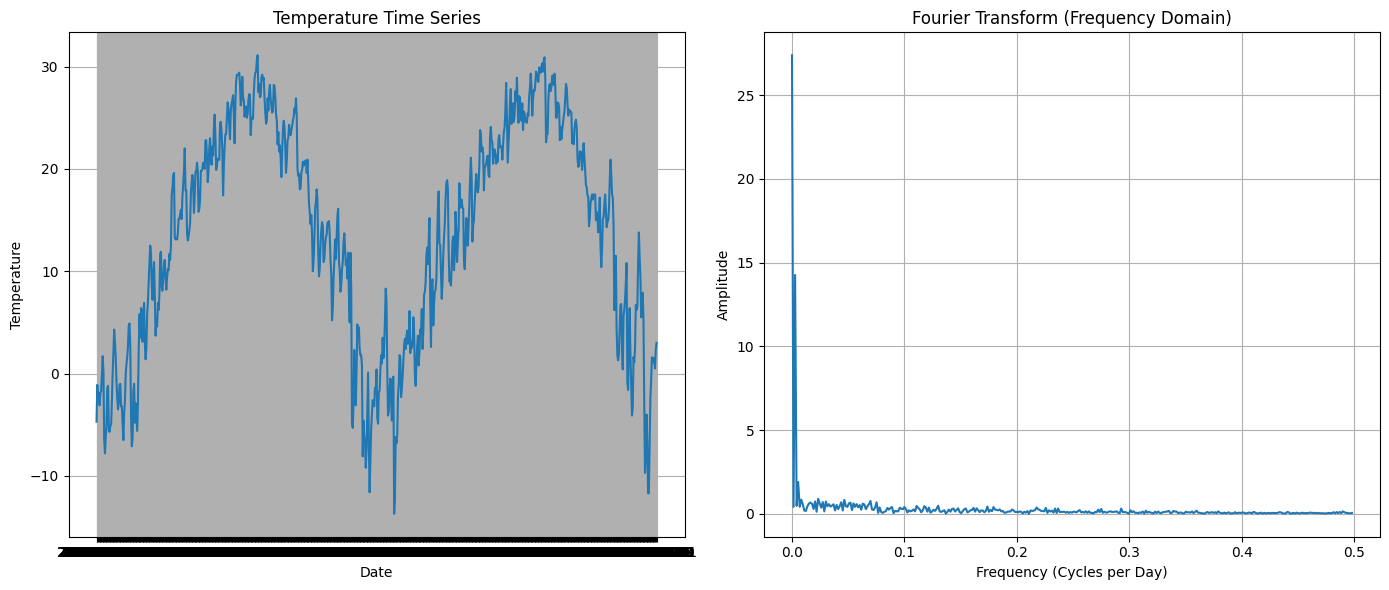

In [ ]:
# Plot the original time series and its Fourier Transform
# If the dominant frequency is centered around 0.0027, this implies a seasonal pattern with a cycle of about 365 days (one year).
# "Frequency = 0.1" repeats 0.1 times per day, so it could be a component of a cycle of about 10 days.
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(weather_data.index, temperature_data, label='Temperature')
plt.title('Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='FFT')
plt.title('Fourier Transform (Frequency Domain)')
plt.xlabel('Frequency (Cycles per Day)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

#### 2.2 Time Entropy
Goal : Measure complexity, predictability, and uncertainty in time series data

Time entropy measures the complexity or unpredictability of a time series. It quantifies the amount of information required to describe the state of the system.

Shannon Entropy: A commonly used measure calculated as
−
∑
𝑝
(
𝑥
)
log
⁡
𝑝
(
𝑥
)
−∑p(x)logp(x), where
𝑝
(
𝑥
)
p(x) is the probability of observing the state
𝑥
x.


In [ ]:
from collections import Counter

def shannon_entropy(data):
    # Count the frequency of each value in the data
    counts = Counter(data)
    # Calculate probabilities
    probabilities = np.array(list(counts.values())) / len(data)
    # Calculate Shannon Entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Calculate Shannon Entropy for temperature data
entropy_value = shannon_entropy(temperature_data)
print(f'Shannon Entropy of Temperature Data: {entropy_value:.4f}')


Shannon Entropy of Temperature Data: 8.1405


## Mobility Data Processing
Mobility data, often recorded as GPS coordinates, can be processed to extract features related to location and movement patterns.

### 3.1 Mobility Data: GPS Coordinates
GPS data consists of latitude and longitude points collected over time. This data can be challenging to use directly in machine learning models.

Semantic Place Identification: Clustering GPS points to identify significant locations, such as home, work, or places frequently visited.

In [ ]:
import pandas as pd
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle


# 1. Sample GPS data (latitude, longitude)
gps_data = pd.DataFrame({
    'latitude': [37.7749, 37.7750, 37.7751, 37.7748, 37.8044, 37.8045, 37.8046, 37.7849, 37.7848, 37.7850],
    'longitude': [122.4194, 122.4195, 122.4196, 122.4193, 122.2712, 122.2713, 122.2714, 122.4094, 122.4093, 122.4095],
    'timestamp': pd.date_range('2024-08-11 10:00:00', periods=10, freq='T')
})

# 2. Define Haversine distance metric
def haversine_distance(coords1, coords2):
    return great_circle(coords1, coords2).meters

# 3. Perform DBSCAN clustering
coords = gps_data[['latitude', 'longitude']].values
dbscan = DBSCAN(eps=200, min_samples=2, metric=haversine_distance).fit(coords)  # eps=200 meters
gps_data['cluster'] = dbscan.labels_

# 4. Interpolate points along the path
def interpolate_path(latitudes, longitudes, num_points=100):
    """Interpolate GPS points between given latitudes and longitudes."""
    latitudes = np.array(latitudes)
    longitudes = np.array(longitudes)
    t = np.linspace(0, 1, len(latitudes))
    interp_t = np.linspace(0, 1, num_points)
    interp_lat = np.interp(interp_t, t, latitudes)
    interp_lon = np.interp(interp_t, t, longitudes)
    return interp_lat, interp_lon

# Generate interpolated GPS points
interp_lat, interp_lon = interpolate_path(gps_data['latitude'], gps_data['longitude'], num_points=200)



<ipython-input-110-e3adc03592e3>:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'timestamp': pd.date_range('2024-08-11 10:00:00', periods=10, freq='T')


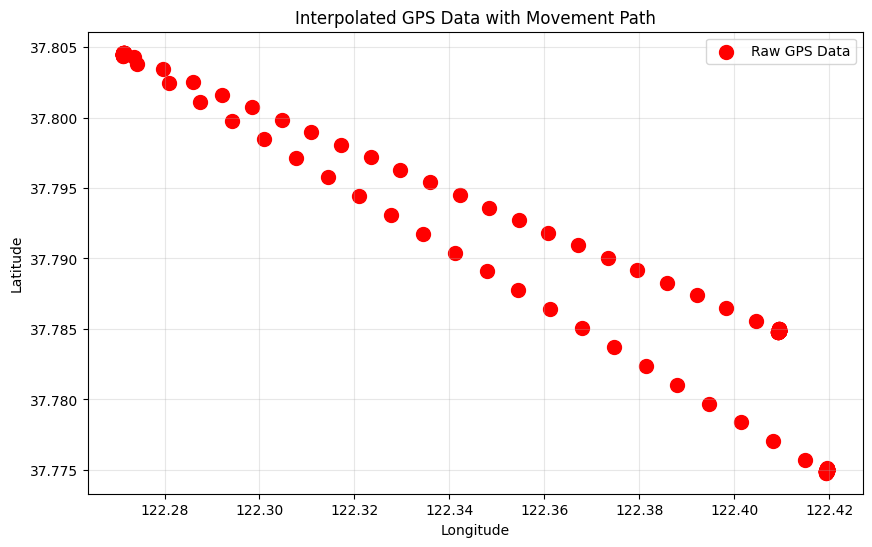

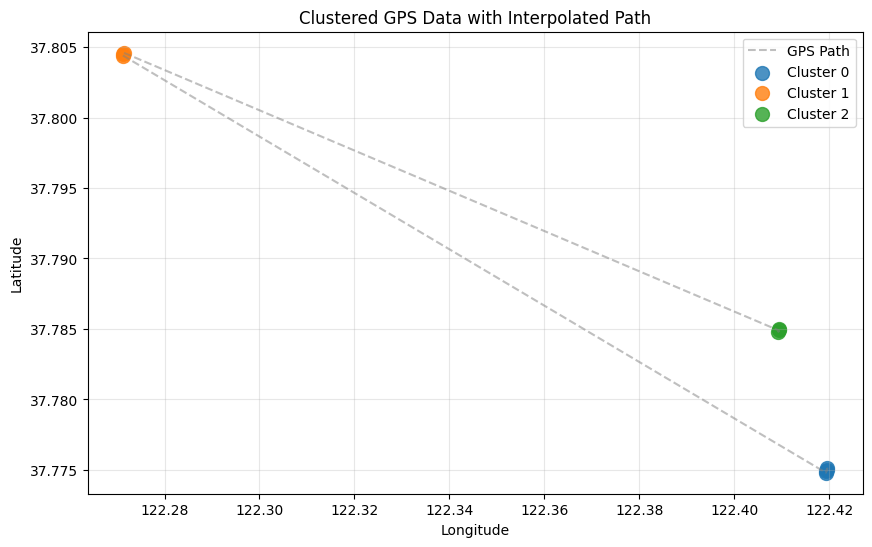


Clustered GPS Data:
   latitude  longitude           timestamp  cluster
0   37.7749   122.4194 2024-08-11 10:00:00        0
1   37.7750   122.4195 2024-08-11 10:01:00        0
2   37.7751   122.4196 2024-08-11 10:02:00        0
3   37.7748   122.4193 2024-08-11 10:03:00        0
4   37.8044   122.2712 2024-08-11 10:04:00        1
5   37.8045   122.2713 2024-08-11 10:05:00        1
6   37.8046   122.2714 2024-08-11 10:06:00        1
7   37.7849   122.4094 2024-08-11 10:07:00        2
8   37.7848   122.4093 2024-08-11 10:08:00        2
9   37.7850   122.4095 2024-08-11 10:09:00        2


In [ ]:
# 5. Plotting the interpolated GPS data with movement path
plt.figure(figsize=(10, 6))

# Interpolated path
plt.scatter(interp_lon, interp_lat, c='red', s=100)

# Original GPS points
plt.scatter(gps_data['longitude'], gps_data['latitude'], c='red', s=100, label='Raw GPS Data')

plt.title("Interpolated GPS Data with Movement Path")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 6. Plotting the clustered GPS data with interpolated path
plt.figure(figsize=(10, 6))

# Interpolated path
plt.plot(interp_lon, interp_lat, linestyle='--', color='gray', alpha=0.5, label='GPS Path')

# Plot clusters
for cluster_id, cluster_data in gps_data.groupby('cluster'):
    color = 'gray' if cluster_id == -1 else None  # Noise points in gray
    label = 'Noise' if cluster_id == -1 else f'Cluster {cluster_id}'
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], s=100, label=label, alpha=0.8, c=color)

plt.title("Clustered GPS Data with Interpolated Path")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Output the GPS data with cluster labels
print("\nClustered GPS Data:")
print(gps_data)

In [ ]:
from scipy.stats import entropy

# Extract Features
def extract_features(data):

    # 1. Location Entropy
    # Entropy measures the diversity of time spent in different clusters
    location_entropy = entropy(cluster_counts)

    # 2. Number of Clusters Visited
    num_clusters = len(cluster_counts)

    # 3. Average Dwell Time per Cluster
    data['time_diff'] = data['timestamp'].diff().dt.total_seconds().fillna(0)
    cluster_dwell_time = data.groupby('cluster')['time_diff'].sum()
    avg_dwell_time = cluster_dwell_time.mean() if len(cluster_dwell_time) > 0 else 0

    # 4. Max Dwell Time
    max_dwell_time = cluster_dwell_time.max() if len(cluster_dwell_time) > 0 else 0

    # Feature Summary
    features = {
        'location_entropy': location_entropy,
        'num_clusters': num_clusters,
        'avg_dwell_time': avg_dwell_time,
        'max_dwell_time': max_dwell_time
    }
    return features

In [ ]:
# Calculate Features
features = extract_features(gps_data)

# Print Extracted Features
print("\nExtracted Features:")
for key, value in features.items():
    print(f"{key}: {value}")



Extracted Features:
location_entropy: 0.6829081047004717
num_clusters: 2
avg_dwell_time: 180.0
max_dwell_time: 180.0


## Text Data Processing
Text data requires specialized processing to convert it into numerical features suitable for machine learning.

### 5.1 Bag of Words
- Represent text data as simply the frequency of occurrence of words
- Use only words, ignoring sequence or contextual information between documents

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Sample text data
text_data = [
    "The cat sat on the mat",
    "Dogs and cats are great pets",
    "Text analysis is a key feature in machine learning"
]

# Generate word frequency vectors with CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text_data)

# Word dictionaries and converted data
print("Vocabulary:", vectorizer.get_feature_names_out())
print("Bag of Words Matrix:\n", X.toarray())

Vocabulary: ['analysis' 'and' 'are' 'cat' 'cats' 'dogs' 'feature' 'great' 'in' 'is'
 'key' 'learning' 'machine' 'mat' 'on' 'pets' 'sat' 'text' 'the']
Bag of Words Matrix:
 [[0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 2]
 [0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0]]


### 5.2 Sentence Embeddings
- Sentence-by-sentence embeddings representing the meaning of a sentence in vector space
- BERT (BBidirectional Encoder Representations from Transformers)

  - By masking random words in a sentence and learning to predict them, the model's representation captures the bi-directional understanding of the sentence

In [ ]:
from sentence_transformers import SentenceTransformer

# Sample text data
text_data = [
    "Artificial intelligence is transforming the world.",
    "Machine learning is a subset of AI.",
    "Deep learning is a powerful tool for AI applications."
]

# Sentence-BERT Loading a Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create a sentence embedding
sentence_embeddings = model.encode(text_data)

# Output embedding for each sentence
for i, embedding in enumerate(sentence_embeddings):
    print(f"Sentence {i + 1} Embedding:\n", embedding)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence 1 Embedding:
 [ 3.87241393e-02 -1.10552053e-03  8.27161744e-02 -1.62885860e-02
  4.65431139e-02 -9.53027792e-03 -2.99748927e-02  3.49418586e-03
  1.11962585e-02  2.63024052e-03 -1.33261513e-02  7.20948800e-02
 -4.09048563e-03  4.32346985e-02 -3.58305462e-02  3.18855792e-02
 -1.07398130e-01 -3.44288349e-02 -1.47344708e-01 -8.24283585e-02
  9.44175851e-03  4.44823503e-02 -1.04593216e-02 -2.27152556e-02
 -6.94131060e-03  5.52090034e-02  2.38689445e-02 -6.28514066e-02
 -2.65044067e-02 -5.03157452e-02  1.60142370e-02  6.18262626e-02
  3.32975835e-02  2.48469878e-02 -2.86043808e-02  8.12884122e-02
  2.73211095e-02 -1.45991156e-02  6.13124371e-02 -4.10649516e-02
  3.10627744e-02 -8.35286379e-02  6.51203748e-03 -2.13338882e-02
  6.93307444e-02  1.36500582e-01 -7.67961219e-02 -3.25734057e-02
 -1.00615108e-03 -3.51930317e-03 -1.30318150e-01 -3.58479321e-02
  2.11035293e-02 -1.34975296e-02 -3.76569480e-02  2.81999093e-02
  9.11419019e-02 -1.88492741e-02  5.50940186e-02 -3.09680626e-02
  